# Solve cartpole with REINFORCE

> By Jonas Busk ([jbusk@dtu.dk](mailto:jbusk@dtu.dk))

**2019 update:** Changes have been made to the display of environments due to the previous `viewer` being incompatible with newer versions of Gym.

In this part, we will create an agent that can learn to solve the [cartpole problem](https://gym.openai.com/envs/CartPole-v0/) from OpenAI Gym by applying a simple policy gradient method called REINFORCE.
In the cartpole problem, we need to balance a pole on a cart that moves along a track by applying left and right forces to the cart.

We will implement a probabilistic policy, that given a state of the environment, $s$, outputs a probability distribution over available actions, $a$:

$$
p_\theta(a|s)
$$

The policy is a neural network with parameters $\theta$ that can be trained with gradient descent.
When the set of available actions is discrete, we can use a network with softmax output do describe the distribution.
The core idea of training the policy network is quite simple: *we want to maximize the expected total reward by increasing the probability of good actions and decreasing the probability of bad actions*. 

To achieve this, we apply the gradient of the expected discounted total reward (return):

$$
\begin{align}
\nabla_\theta \mathbb{E}[R|\theta] &= \nabla_\theta \int p_\theta(a|s) R({a}) \, da \\
&= \int \nabla_\theta p_\theta(a|s) R(a)  \, da \\
&= \int p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) R(a) \, da \\
&= \mathbb{E}[\nabla_\theta \log p_\theta(a|s) R(a)]
\end{align}
$$

by definition of expectation and using the identity 

$$
\nabla_\theta p_\theta(a|s) = p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) \ .
$$

The expectation cannot be evaluated analytically, but we have an environment simulator that when supplied with our current policy $p_\theta(a|s)$ can return a sequence of *actions*, *states* and *rewards*. This allows us to replace the integral with a Monte Carlo average:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) R_t \ ,
$$

which is our final gradient estimator, also known as REINFORCE. In the Monte Carlo estimator we run the environment simulator for a predefined number of steps with actions chosen stochastically according to the current stochastic action network $p_\theta(a|s)$.

*Note: For simple reinforcement learning problems (like the one we will address in this exercise) there are simpler methods that work just fine. However, the Policy Gradient method (with some extensions) has been shown to also work well for complex problems with high dimensional inputs and many parameters, where simple methods become inadequate.*

## Policy gradient

In [1]:
# Install colabgymrender to display gym environments in Colab
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
from gym import wrappers
from colabgymrender.recorder import Recorder

First we create the environment:

In [3]:
env = gym.make('CartPole-v0') # Create environment

A state in this environment is four numbers describing the position of the cart along with the angle and speed of the pole.
There are two available actions: push the cart *left* or *right* encoded as 0 and 1.

In [4]:
s = env.reset()
a = env.action_space.sample()
print('sample state:', s)
print('sample action:', a )

sample state: [ 0.03147739 -0.00631388 -0.02506941 -0.00771587]
sample action: 0


Let us see how the environment looks when we just take random actions. Note that the episode ends when the pole either 1) is more than 15 degrees from vertical, 2) more outside of the frame or 3) the pole is successfully balanced for some fixed duration.

In [5]:
env = gym.make('CartPole-v0') # Create environment
env = Recorder(env, "./video") # To display environment in Colab
env.reset() # Reset environment

# Run environment
while True:
    env.render() # Render environment
    action = env.action_space.sample() # Get a random action
    _, _, done, _ = env.step(action) # Take a step
    if done: break # Break if environment is done

env.close() # Close environment
env.play()

100%|██████████| 46/46 [00:00<00:00, 265.64it/s]


Taking random actions does not do a very good job at balancing the pole. Let us now apply the Policy Gradient method described above to solve this task!

Let's first define our network and helper functions.

In [6]:
class PolicyNet(nn.Module):
    """Policy network"""

    def __init__(self, n_inputs, n_hidden, n_outputs, learning_rate):
        super(PolicyNet, self).__init__()
        # network
        self.hidden = nn.Linear(n_inputs, n_hidden)
        self.out = nn.Linear(n_hidden, n_outputs)
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = self.hidden(x)
        x = F.relu(x)
        x = self.out(x)
        return F.softmax(x, dim=1)
    
    def loss(self, action_probabilities, returns):
        return -torch.mean(torch.mul(torch.log(action_probabilities), returns))

In [7]:
def compute_returns(rewards, discount_factor):
    """Compute discounted returns."""
    returns = np.zeros(len(rewards))
    returns[-1] = rewards[-1]
    for t in reversed(range(len(rewards)-1)):
        returns[t] = rewards[t] + discount_factor * returns[t+1]
    return returns

To start with, our policy will be a rather simple neural network with one hidden layer. We can retrieve the shape of the state space (input) and action space (output) from the environment.

In [8]:
n_inputs = env.observation_space.shape[0]
n_hidden = 50
n_outputs = env.action_space.n

print('state shape:', n_inputs)
print('action shape:', n_outputs)

state shape: 4
action shape: 2


In [9]:
# training settings

num_episodes = 2000
rollout_limit = 500 # max rollout length
discount_factor = 0.95 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.01 # you know this by now
val_freq = 100 # validation frequency

# setup policy network

policy = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate)

# train policy network

try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        rollout = []
        s = env.reset()
        for j in range(rollout_limit):
            # generate rollout by iteratively evaluating the current policy on the environment
            with torch.no_grad():
                a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                a = torch.multinomial(a_prob, num_samples=1).squeeze().numpy()
            s1, r, done, _ = env.step(a)
            rollout.append((s, a, r))
            s = s1
            if done: break
        # prepare batch
        rollout = np.array(rollout)
        states = np.vstack(rollout[:,0])
        actions = np.vstack(rollout[:,1])
        rewards = np.array(rollout[:,2], dtype=float)
        returns = compute_returns(rewards, discount_factor)
        # policy gradient update
        policy.optimizer.zero_grad()
        a_probs = policy(torch.from_numpy(states).float()).gather(1, torch.from_numpy(actions)).view(-1)
        loss = policy.loss(a_probs, torch.from_numpy(returns).float())
        loss.backward()
        policy.optimizer.step()
        # bookkeeping
        training_rewards.append(sum(rewards))
        losses.append(loss.item())
        # print
        if (i+1) % val_freq == 0:
            # validation
            validation_rewards = []
            for _ in range(10):
                s = env.reset()
                reward = 0
                for _ in range(rollout_limit):
                    with torch.no_grad():
                        a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                        a = a_prob.argmax().item()
                    s, r, done, _ = env.step(a)
                    reward += r
                    if done: break
                validation_rewards.append(reward)
            print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards), np.mean(losses[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')    

start training
 100. mean training reward:  12.60, mean validation reward:   9.40, mean loss:  2.9565
 200. mean training reward:  12.36, mean validation reward:  10.00, mean loss:  2.6610
 300. mean training reward:  12.07, mean validation reward:   9.40, mean loss:  2.1153
 400. mean training reward:   9.52, mean validation reward:   9.30, mean loss:  0.3221
 500. mean training reward:   9.40, mean validation reward:   9.40, mean loss:  0.3635
 600. mean training reward:   9.76, mean validation reward:   9.40, mean loss:  0.6698
 700. mean training reward:   9.54, mean validation reward:   9.70, mean loss:  0.6864
 800. mean training reward:  13.53, mean validation reward:  11.00, mean loss:  3.1102
 900. mean training reward:  19.44, mean validation reward:  19.50, mean loss:  4.3770
1000. mean training reward:  56.89, mean validation reward: 127.20, mean loss:  5.6392
1100. mean training reward:  85.65, mean validation reward: 140.60, mean loss:  4.9577
1200. mean training reward: 

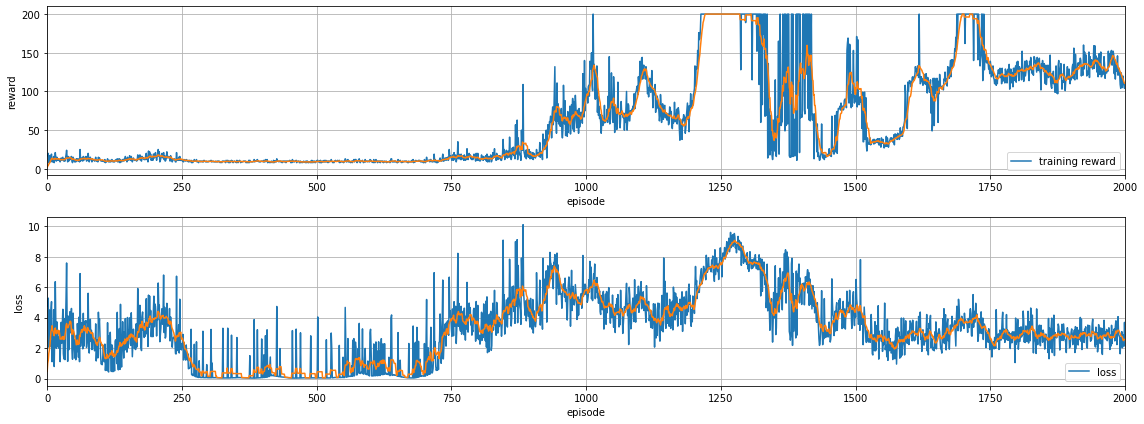

In [10]:
# plot results
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,6))
plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()

Now let's review the solution!

In [11]:
env = Recorder(env, "./gym-results") # wrappers.Monitor(env, "./gym-results", force=True) # Create wrapper to display environment
s = env.reset()

for _ in range(500):
    env.render()
    a = policy(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
    s, r, done, _ = env.step(a)
    if done: break
    
# env.close()
env.play()

100%|██████████| 106/106 [00:00<00:00, 236.76it/s]


## Reducing variance

By default, this gradient estimator has high variance and therefore variance reduction becomes important to learn more complex tasks.
We can reduce variance by subtracting a baseline from the returns, which is unbiased in expectation:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) (R_t-b_t) \ ,
$$

where the baseline, $b_t$, is estimated by the return a timestep $t$ averaged over $V$ rollouts.

$$
b_t = \frac{1}{V} \sum_{v=1}^V R_t^{(v)} \ .
$$

## Exercises

Now it is your turn! Make sure you read and understand the code, then play around with it and try to make it learn better and faster.

Experiment with the:

* number of episodes
* discount factor
* learning rate
* network layers


### Exercise 1 

*Describe any changes you made to the code and why you think they improve the agent. Are you able to get solutions consistently?*

**Answer:**

I experimented with many different parameters and most of the combinations ended with no learning at all or peaking to 200 reward on certain episodes to immediately drop after. This way the results were super random. I increased the size of the hidden layer to 50 nodes but as it made the net more complicated I reduced the learning rate to 0.01 so we can learn faster. Discount factor was by default 1 so we assumed that same series of actions leads to the same results which is not the case here. I decresed the discount factor to 0.95 and immediately got better results. In the end I increased the number of episodes to 2000 to be sure that I learn a stable solution.

The result is very interesting as the final model might not be the best but it achieves a stable reward of over a 100 by simply moving in the opposite direction of the initial lean of the stick. By doing that it can keep it fairly straight until it goes out of bounds.

### Exercise 2 

*Consider the following sequence of rewards produced by an agent interacting with an environment for 10 timesteps:*

[0, 1, 1, 1, 0, 1, 1, 0, 0, 0]

* *What is the total reward?*
* *What is the total future reward in each timestep?*
* *What is the discounted future reward in each timestep if $\gamma = 0.9$?*

*Hint: See introdution notebook.*

**Answer:**

 - A reward of +1 is provided for every timestep that the pole remains upright. In this case its 5 then.
 - Based on the introduction "Given a series of transitions consisting of $T$ timesteps, it is straight forward to compute the **total future reward** or **return** from time, $t$:

    $$
    %R_t = r_t + r_{t+1} + r_{t+2} + \dots + r_T \ .
    R_t = r_t + r_{t+1} + r_{t+2} + \dots + r_T = \sum_{k=0}^{T-t} r_{t+k} \ .
    $$" So in this case our total future rewards will be [5,5,4,3,2,2,1,0,0,0] where each element of the list represents one timestep.

-  Based on the introduction in **discounted return** rewards are weighted by uncertainty:

    $$
    %R_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \dots + \gamma^{T} r_T = r_t + \gamma R_{t+1} \ ,
    R_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \dots + \gamma^{T} r_T = \sum_{k=0}^{T-t} \gamma^k r_{t+k} \ ,
    $$

    where $\gamma \in [0,1]$ is the **discount rate**. So in our case 




In [12]:
results = []
timestamps = [0, 1, 1, 1, 0, 1, 1, 0, 0, 0]
for i in range(10):
    results.append(np.sum(timestamps[i:10]*np.cumprod([1]+[0.9]*(9-i))))
results

[3.5609310000000005,
 3.9565900000000003,
 3.2851,
 2.539,
 1.71,
 1.9,
 1.0,
 0.0,
 0.0,
 0]

### Exercise 3

*In the training output, you will sometimes observe the validation reward starts out lower than the training reward but as training progresses they cross over and the validation reward becomes higher than the training reward. How can you explain this behavior?*

*Hint: Do we use the policy network in the same way during training and validation?*

**Answer:**

If we look at the implementation we can see that the training reward is actually including rewards when we are doing the exploration part. It means that have lower probabilities of being the best but we want to try them to avoid local maxima. Thus, we achieve worse performance than for the validation reward which is calculated by just taking the actions with the highest probabilities in the current state. At some we might find the best solution but the training still explores different ones. That's when we might reach the maximum validation reward and have a lower training reward.

### Exercise 4

*How does the policy gradient method we have used address the exploration-exploitation dilemma?*

*Hint: See the introduction notebook about exploration-exploitation.*

**Answer:**

If we only explore possible solutions our model goes through large number of different solutions but does not really learn from them. If we only exploit the space we quickly go into local maxima but probably won't learn the best solution. By using policy gradient method we address the exploration-exploitation dilemma by increasing the probability of choosing a solution that resulted in a high reward but at the same time we still have a chance of exploring different solutions with lower probabilities. If they turn to be good we adjust the probabilities again and repeat the process having much higher chance of finding the best solution.

### Exercise 5 [optional]

Extend the code above to reduce variance of the gradient estimator by computing and subtracting the baseline estimate. 

*Hint: You need to sample a batch of rollouts (now we sample just one) for each update in order to compute the baseline, $b_t$.*